In [1]:
!pip install pandas matplotlib seaborn --quiet

In [2]:
!pip install lightgbm scikit-learn --quiet

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_columns = 200
pd.options.display.max_rows = 200

## Constants

In [4]:
ID_COL = "customerID"

In [5]:
target_col = "Churn"
categorical_cols = [
    "gender",
    "Partner",
    "SeniorCitizen",
    "Dependents",
    "PhoneService",
    "PaperlessBilling",
]
dummies = [
    "InternetService",
    "OnlineSecurity",
    "OnlineBackup",
    "DeviceProtection",
    "TechSupport",
    "StreamingTV",
    "StreamingMovies",
    "MultipleLines",
    "Contract",
    "PaymentMethod"
]
numeric_cols = [
    "tenure",
    "Charges.Monthly",
    "Charges.Total"
]

## Get data


In [6]:
df = pd.read_csv("etl_dataframe.csv").set_index("Unnamed: 0").reset_index(drop=True).set_index(ID_COL)
df.head()

,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PhoneService,MultipleLines,Contract,PaperlessBilling,PaymentMethod,Charges.Monthly,Charges.Total
customerID,,,,,,,,,,,,,,,,,,,,
0002-ORFBO,No,Female,0,Yes,Yes,9,DSL,No,Yes,No,Yes,Yes,No,Yes,No,One year,Yes,Mailed check,65.6,593.3
0003-MKNFE,No,Male,0,No,No,9,DSL,No,No,No,No,No,Yes,Yes,Yes,Month-to-month,No,Mailed check,59.9,542.4
0004-TLHLJ,Yes,Male,0,No,No,4,Fiber optic,No,No,Yes,No,No,No,Yes,No,Month-to-month,Yes,Electronic check,73.9,280.85
0011-IGKFF,Yes,Male,1,Yes,No,13,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes,No,Month-to-month,Yes,Electronic check,98.0,1237.85
0013-EXCHZ,Yes,Female,1,Yes,No,3,Fiber optic,No,No,No,Yes,Yes,No,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.4


## Analyse


### Numeric

In [7]:
df.describe()

,SeniorCitizen,tenure,Charges.Monthly
count,7267.000000,7267.000000,7267.000000
mean,0.162653,32.346498,64.720098
std,0.369074,24.571773,30.129572
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.425000
50%,0.000000,29.000000,70.300000
75%,0.000000,55.000000,89.875000
max,1.000000,72.000000,118.750000


<Axes: ylabel='Frequency'>

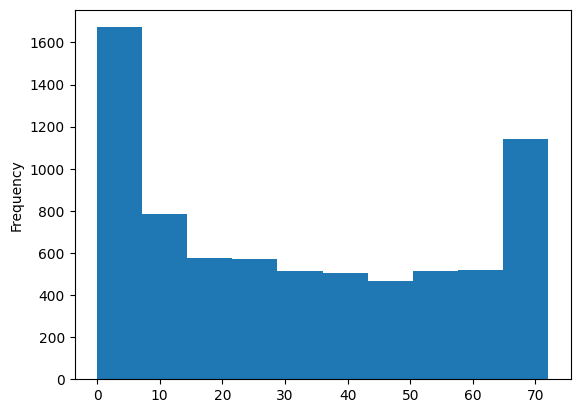

In [8]:
df["tenure"].plot(kind="hist")

<Axes: ylabel='Frequency'>

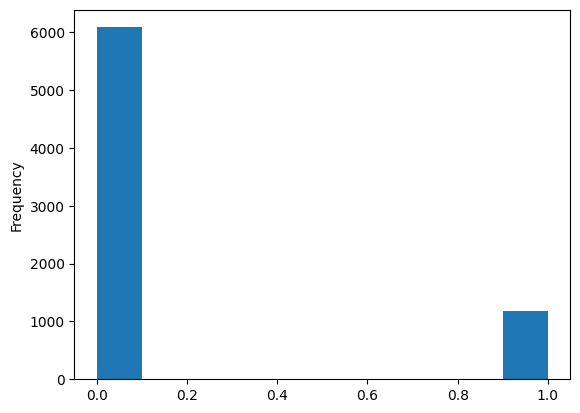

In [9]:
df["SeniorCitizen"].plot(kind="hist")

<Axes: ylabel='Frequency'>

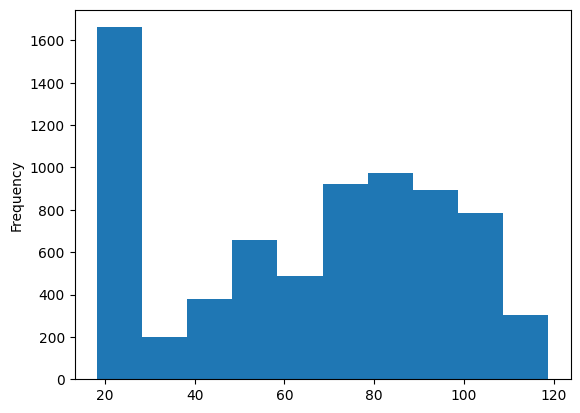

In [10]:
df["Charges.Monthly"].plot(kind="hist")

### Categorical


In [11]:
df.describe(include=["object"]).T

,count,unique,top,freq
Churn,7043,2,No,5174
gender,7267,2,Male,3675
Partner,7267,2,No,3749
Dependents,7267,2,No,5086
InternetService,7267,3,Fiber optic,3198
OnlineSecurity,7267,3,No,3608
OnlineBackup,7267,3,No,3182
DeviceProtection,7267,3,No,3195
TechSupport,7267,3,No,3582
StreamingTV,7267,3,No,2896


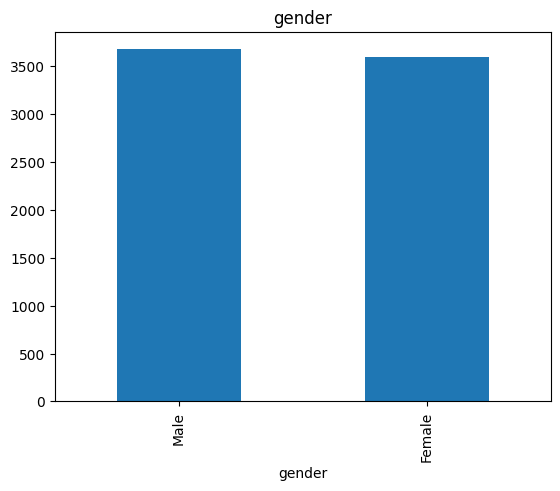

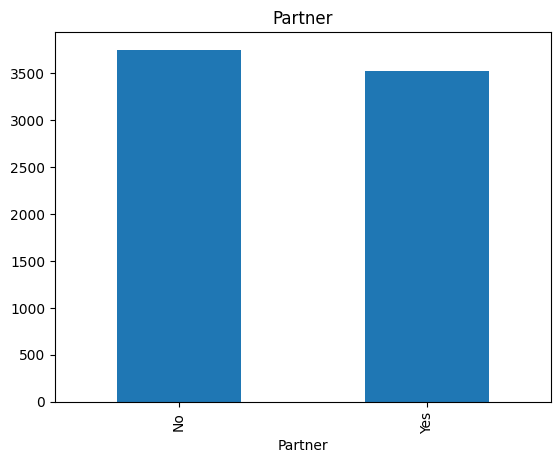

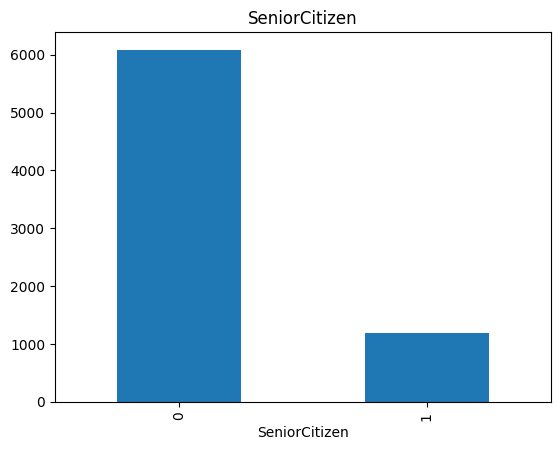

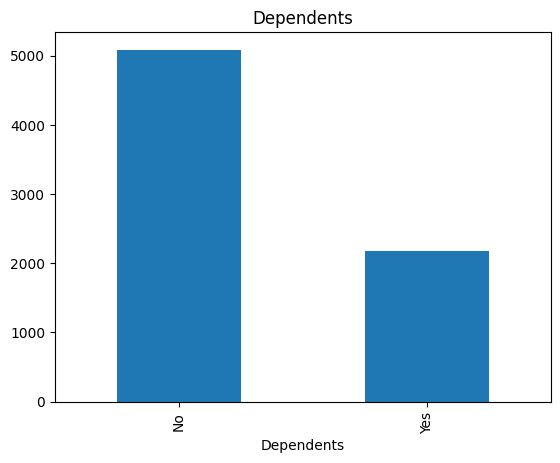

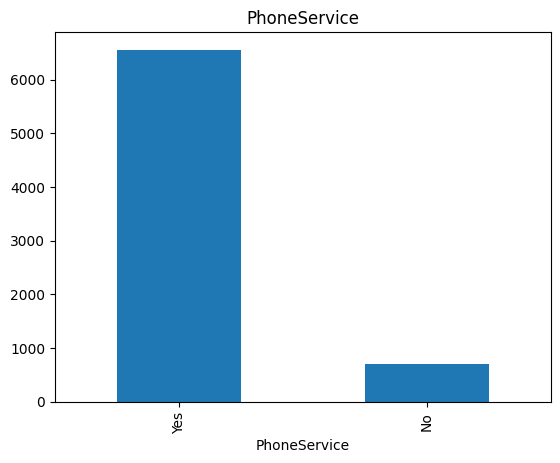

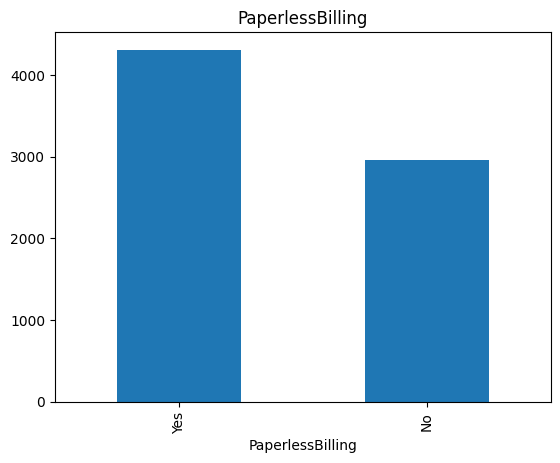

In [12]:
for col in categorical_cols:
    df[col].value_counts().plot(kind="bar", title=col)
    plt.show()

## Preprocess

In [13]:
data = df.copy()

In [14]:
def transform(df, dummies):
    df["tenure"] = df["tenure"].replace({"": np.nan}).replace(' ', np.nan)
    df = (
        df
        .assign(
            Churn=lambda x: x["Churn"].map({"Yes": 1, "No": 0, "": np.nan}),
            gender=lambda x: x["gender"].map({"Male": 1, "Female": 0, "": np.nan}),
            Partner=lambda x: x["Partner"].map({"Yes": 1, "No": 0, "": np.nan}),
            PhoneService=lambda x: x["PhoneService"].map({"Yes": 1, "No": 0, "": np.nan}),
            PaperlessBilling=lambda x: x["PaperlessBilling"].map({"Yes": 1, "No": 0, "": np.nan}),
            Dependents=lambda x: x["Dependents"].map({"Yes": 1, "No": 0, "": np.nan}),
        )
    )
    df = pd.get_dummies(df, columns=dummies, drop_first=True)
    # Convert all dummy columns to int type
    df["Charges.Total"] = pd.to_numeric(df["Charges.Total"], errors='coerce')
    dummy_cols = [col for col in df.columns if any(d in col for d in dummies)]
    df[dummy_cols] = df[dummy_cols].astype(int)
    return df

df = transform(data, dummies)

In [15]:
df.shape

(7267, 31)

In [16]:
df.head()

,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,Charges.Monthly,Charges.Total,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,MultipleLines_No phone service,MultipleLines_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
customerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0002-ORFBO,0.0,0.0,0,1.0,1.0,9,1.0,1.0,65.6,593.30,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1
0003-MKNFE,0.0,1.0,0,0.0,0.0,9,1.0,0.0,59.9,542.40,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1
0004-TLHLJ,1.0,1.0,0,0.0,0.0,4,1.0,1.0,73.9,280.85,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
0011-IGKFF,1.0,1.0,1,1.0,0.0,13,1.0,1.0,98.0,1237.85,1,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0
0013-EXCHZ,1.0,0.0,1,1.0,0.0,3,1.0,1.0,83.9,267.40,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1


In [17]:
for col in categorical_cols:
    display(df[col].value_counts())

,count
gender,
1.0,3675
0.0,3592


,count
Partner,
0.0,3749
1.0,3518


,count
SeniorCitizen,
0,6085
1,1182


,count
Dependents,
0.0,5086
1.0,2181


,count
PhoneService,
1.0,6560
0.0,707


,count
PaperlessBilling,
1.0,4311
0.0,2956


## Statistic

In [18]:
# Clean numeric columns before correlation to avoid ValueError from non-numeric values
df_clean = df
df_clean = df_clean.apply(pd.to_numeric, errors='coerce')
df_clean.corr()

,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,Charges.Monthly,Charges.Total,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,MultipleLines_No phone service,MultipleLines_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
Churn,1.000000,-0.008612,0.150889,-0.150448,-0.164221,-0.352229,0.011942,0.191825,0.193356,-0.199484,0.308020,-0.227890,-0.227890,-0.171226,-0.227890,-0.082255,-0.227890,-0.066160,-0.227890,-0.164674,-0.227890,0.063228,-0.227890,0.061382,-0.011942,0.040102,-0.177820,-0.302253,-0.134302,0.301919,-0.091683
gender,-0.008612,1.000000,-0.004288,-0.005007,0.012038,0.005765,-0.005073,-0.011273,-0.013889,0.000488,-0.009572,0.006318,0.006318,-0.016974,0.006318,-0.013494,0.006318,-0.002740,0.006318,-0.009112,0.006318,-0.008451,0.006318,-0.012475,0.005073,-0.007805,0.007328,-0.005449,0.000700,0.002060,0.015057
SeniorCitizen,0.150889,-0.004288,1.000000,0.022970,-0.212952,0.018187,0.010060,0.157734,0.220388,0.103499,0.255271,-0.182697,-0.182697,-0.037953,-0.182697,0.068824,-0.182697,0.060358,-0.182697,-0.059376,-0.182697,0.103655,-0.182697,0.119374,-0.010060,0.144567,-0.046832,-0.114837,-0.022698,0.170705,-0.154216
Partner,-0.150448,-0.005007,0.022970,1.000000,0.448900,0.377551,0.018828,-0.011201,0.097122,0.316918,0.002678,0.000419,0.000419,0.141392,0.000419,0.139523,0.000419,0.153209,0.000419,0.116228,0.000419,0.124754,0.000419,0.115729,-0.018828,0.141187,0.081021,0.246472,0.081613,-0.079629,-0.097648
Dependents,-0.164221,0.012038,-0.212952,0.448900,1.000000,0.159892,-0.003863,-0.111752,-0.115832,0.063960,-0.168028,0.142274,0.142274,0.083951,0.142274,0.023686,0.142274,0.014797,0.142274,0.062586,0.142274,-0.015030,0.142274,-0.040151,0.003863,-0.027894,0.068755,0.203136,0.061608,-0.151749,0.060222
tenure,-0.352229,0.005765,0.018187,0.377551,0.159892,1.000000,0.010205,0.007949,0.247982,0.825118,0.020815,-0.037029,-0.037029,0.327252,-0.037029,0.361291,-0.037029,0.361792,-0.037029,0.322139,-0.037029,0.280738,-0.037029,0.286841,-0.010205,0.331678,0.205970,0.557675,0.235319,-0.207056,-0.234305
PhoneService,0.011942,-0.005073,0.010060,0.018828,-0.003863,0.010205,1.000000,0.013624,0.246709,0.113791,0.291040,0.173109,0.173109,-0.093341,0.173109,-0.052165,0.173109,-0.073033,0.173109,-0.097573,0.173109,-0.025362,0.173109,-0.034345,-1.000000,0.280379,-0.001391,0.003888,-0.010668,0.004788,-0.002225
PaperlessBilling,0.191825,-0.011273,0.157734,-0.011201,-0.111752,0.007949,0.013624,1.000000,0.353714,0.159303,0.327790,-0.324473,-0.324473,-0.001693,-0.324473,0.131187,-0.324473,0.105211,-0.324473,0.037581,-0.324473,0.224574,-0.324473,0.212443,-0.013624,0.163225,-0.050372,-0.147611,-0.011702,0.209019,-0.206450
Charges.Monthly,0.193356,-0.013889,0.220388,0.097122,-0.115832,0.247982,0.246709,0.353714,1.000000,0.652109,0.788453,-0.763772,-0.763772,0.298307,-0.763772,0.442974,-0.763772,0.483590,-0.763772,0.338429,-0.763772,0.628874,-0.763772,0.628184,-0.246709,0.490699,0.008758,-0.077935,0.031610,0.275550,-0.378635
Charges.Total,-0.199484,0.000488,0.103499,0.316918,0.063960,0.825118,0.113791,0.159303,0.652109,1.000000,0.362778,-0.374618,-0.374618,0.413705,-0.374618,0.512878,-0.374618,0.524712,-0.374618,0.431987,-0.374618,0.516900,-0.374618,0.521245,-0.113791,0.468926,0.175040,0.354547,0.184990,-0.057178,-0.295076


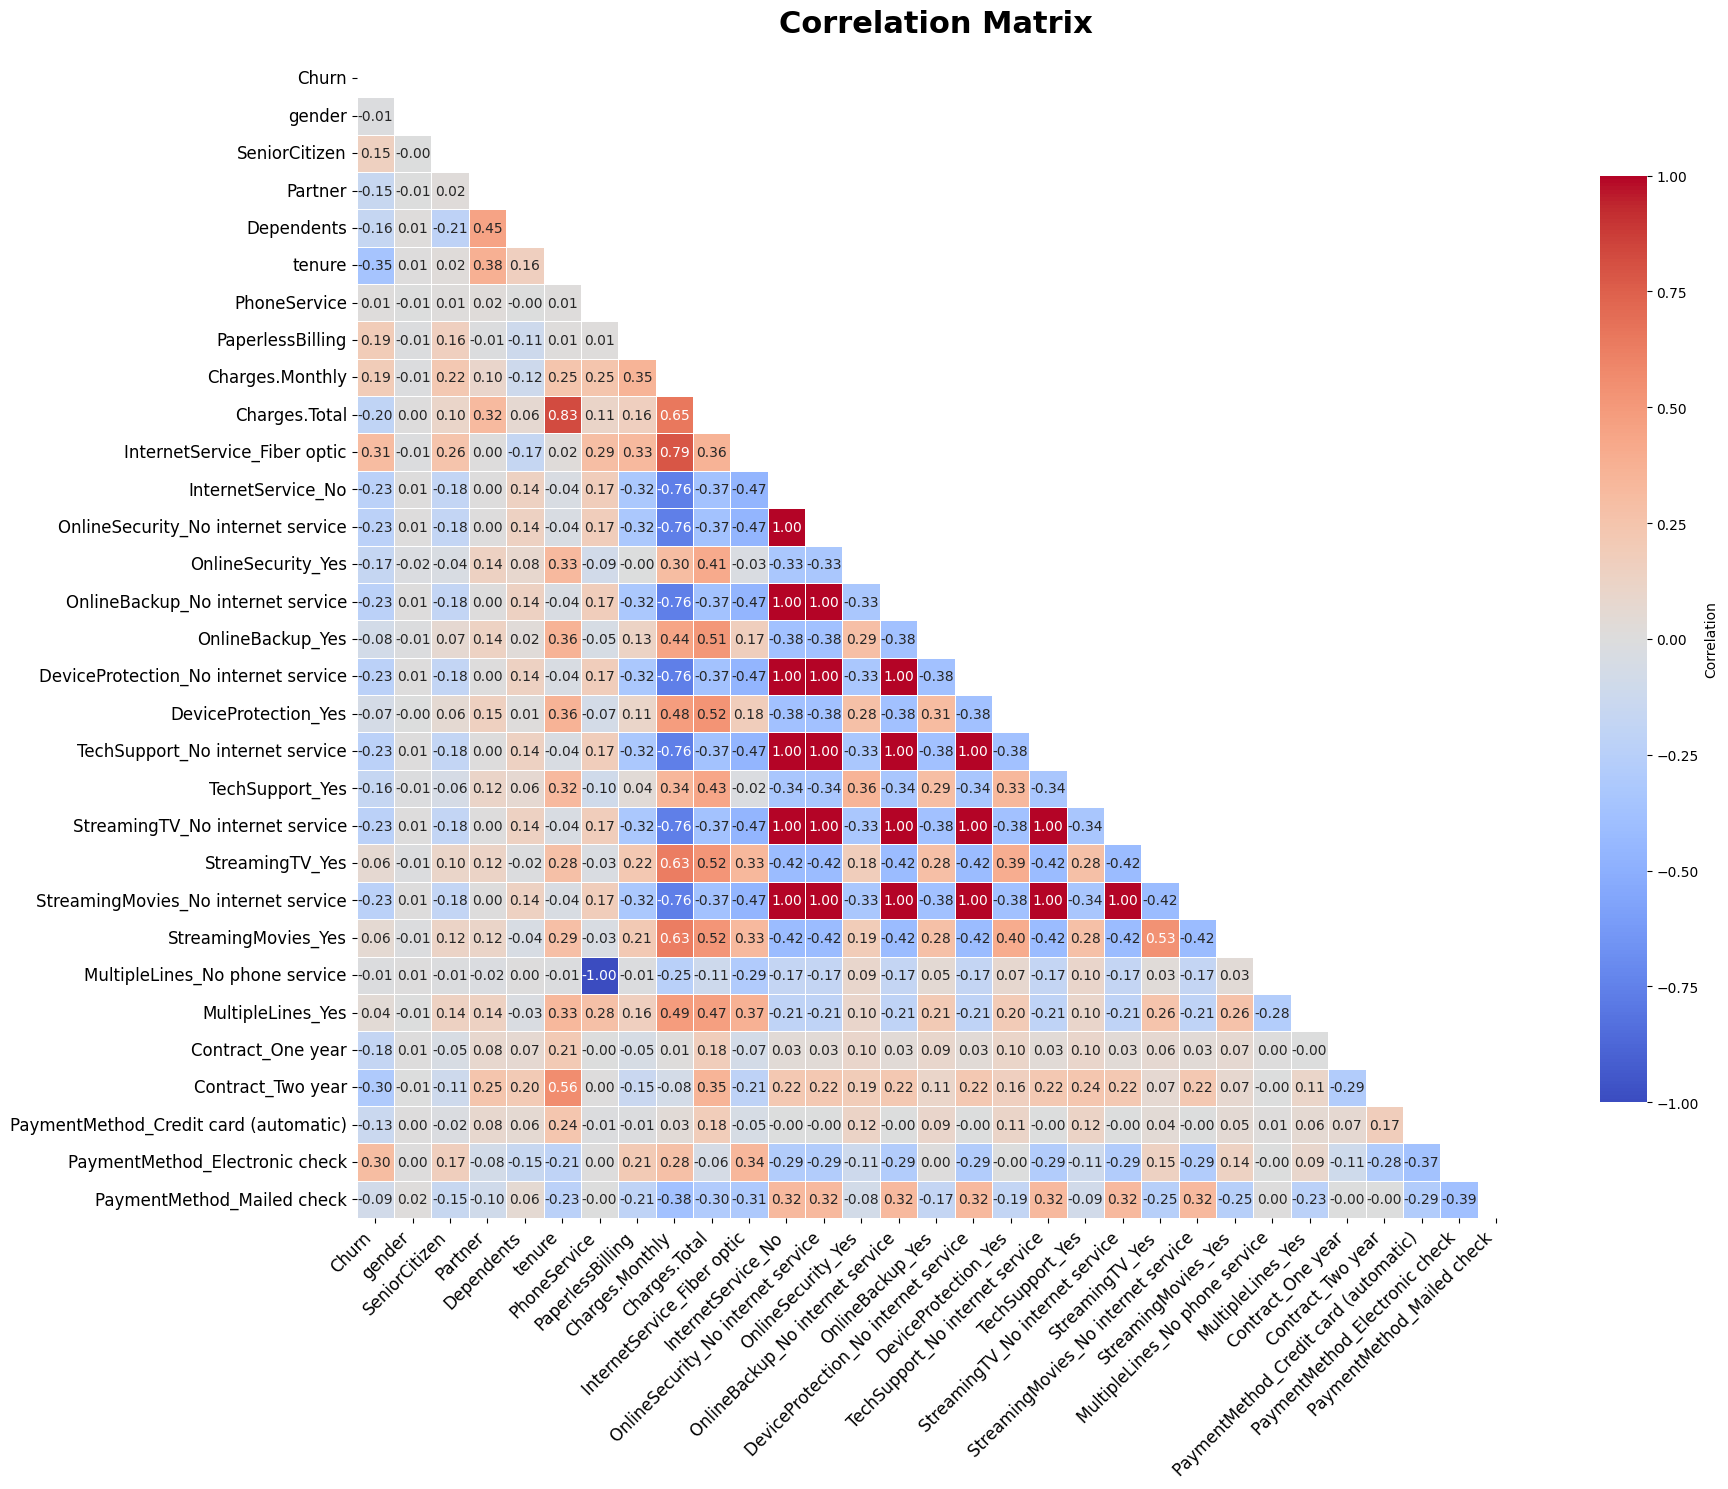

In [19]:
corr = df_clean.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(20, 15))
sns.heatmap(
    corr,
    mask=mask,
    cmap="coolwarm",
    annot=True,
    fmt=".2f",
    linewidths=0.5,
    linecolor='white',
    cbar_kws={"shrink": 0.8, "label": "Correlation"},
    square=True,
)
plt.title("Correlation Matrix", fontsize=22, fontweight='bold', pad=20)
plt.xticks(fontsize=12, rotation=45, ha='right')
plt.yticks(fontsize=12, rotation=0)
plt.tight_layout()
plt.show()

In [20]:
corr[target_col].abs().sort_values(ascending=False)

,Churn
Churn,1.000000
tenure,0.352229
InternetService_Fiber optic,0.308020
Contract_Two year,0.302253
PaymentMethod_Electronic check,0.301919
InternetService_No,0.227890
OnlineSecurity_No internet service,0.227890
TechSupport_No internet service,0.227890
DeviceProtection_No internet service,0.227890
StreamingTV_No internet service,0.227890


# Model

In [21]:
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report

In [22]:
df_nonan = df.dropna(subset=[target_col])
X = df_nonan.drop(columns=[target_col])
y = df_nonan[target_col]

In [23]:
# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [24]:
lgbm = LGBMClassifier(random_state=42, n_estimators=30, is_balance=True)

# Cross-validation on training set
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(lgbm, X_train, y_train, cv=cv, scoring='accuracy')

print("Cross-validation accuracy scores:", cv_scores)
print("Mean CV accuracy: {:.4f} (+/- {:.4f})".format(cv_scores.mean(), cv_scores.std()))

# Train on full training set
lgbm.fit(X_train, y_train)


[LightGBM] [Warning] Unknown parameter: is_balance
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: is_balance
[LightGBM] [Info] Number of positive: 1196, number of negative: 3311
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001062 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 637
[LightGBM] [Info] Number of data points in the train set: 4507, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265365 -> initscore=-1.018268
[LightGBM] [Info] Start training from score -1.018268
[LightGBM] [Warning] Unknown parameter: is_balance
[LightGBM] [Warning] Unknown parameter: is_balance
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: is_balance
[LightGBM] [Info] Number of pos

LGBMClassifier(is_balance=True, n_estimators=30, random_state=42)

In [25]:
# Validation set performance
y_pred = lgbm.predict(X_val)
val_acc = accuracy_score(y_val, y_pred)
print("Validation Accuracy: {:.4f}".format(val_acc))
print("Classification Report:\n", classification_report(y_val, y_pred))

[LightGBM] [Warning] Unknown parameter: is_balance
Validation Accuracy: 0.7942
Classification Report:
               precision    recall  f1-score   support

         0.0       0.83      0.91      0.87      1035
         1.0       0.65      0.49      0.56       374

    accuracy                           0.79      1409
   macro avg       0.74      0.70      0.71      1409
weighted avg       0.78      0.79      0.78      1409



In [26]:
# Validation set performance
y_pred = lgbm.predict(X_val)
val_acc = accuracy_score(y_val, y_pred)
print("Validation Accuracy: {:.4f}".format(val_acc))
print("Classification Report:\n", classification_report(y_val, y_pred))

[LightGBM] [Warning] Unknown parameter: is_balance
Validation Accuracy: 0.7942
Classification Report:
               precision    recall  f1-score   support

         0.0       0.83      0.91      0.87      1035
         1.0       0.65      0.49      0.56       374

    accuracy                           0.79      1409
   macro avg       0.74      0.70      0.71      1409
weighted avg       0.78      0.79      0.78      1409



In [27]:
df[target_col].value_counts(1)

,proportion
Churn,
0.0,0.73463
1.0,0.26537


In [28]:
from sklearn.metrics import roc_auc_score

# Get predicted probabilities for the positive class
if hasattr(lgbm, "predict_proba"):
    y_proba = lgbm.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_proba)
    print("Validation ROC AUC: {:.4f}".format(auc))
else:
    print("Model does not support probability prediction for AUC calculation.")


[LightGBM] [Warning] Unknown parameter: is_balance
Validation ROC AUC: 0.8448


Feature importances:
Charges.Monthly                          220
Charges.Total                            163
tenure                                   137
PaymentMethod_Electronic check            40
PaperlessBilling                          31
OnlineSecurity_Yes                        30
Contract_Two year                         30
gender                                    28
StreamingMovies_Yes                       25
Contract_One year                         25
TechSupport_Yes                           21
OnlineBackup_Yes                          21
SeniorCitizen                             19
InternetService_Fiber optic               18
PhoneService                              16
InternetService_No                        15
StreamingTV_Yes                           15
MultipleLines_Yes                         15
Dependents                                 8
Partner                                    8
DeviceProtection_Yes                       7
PaymentMethod_Mailed check        

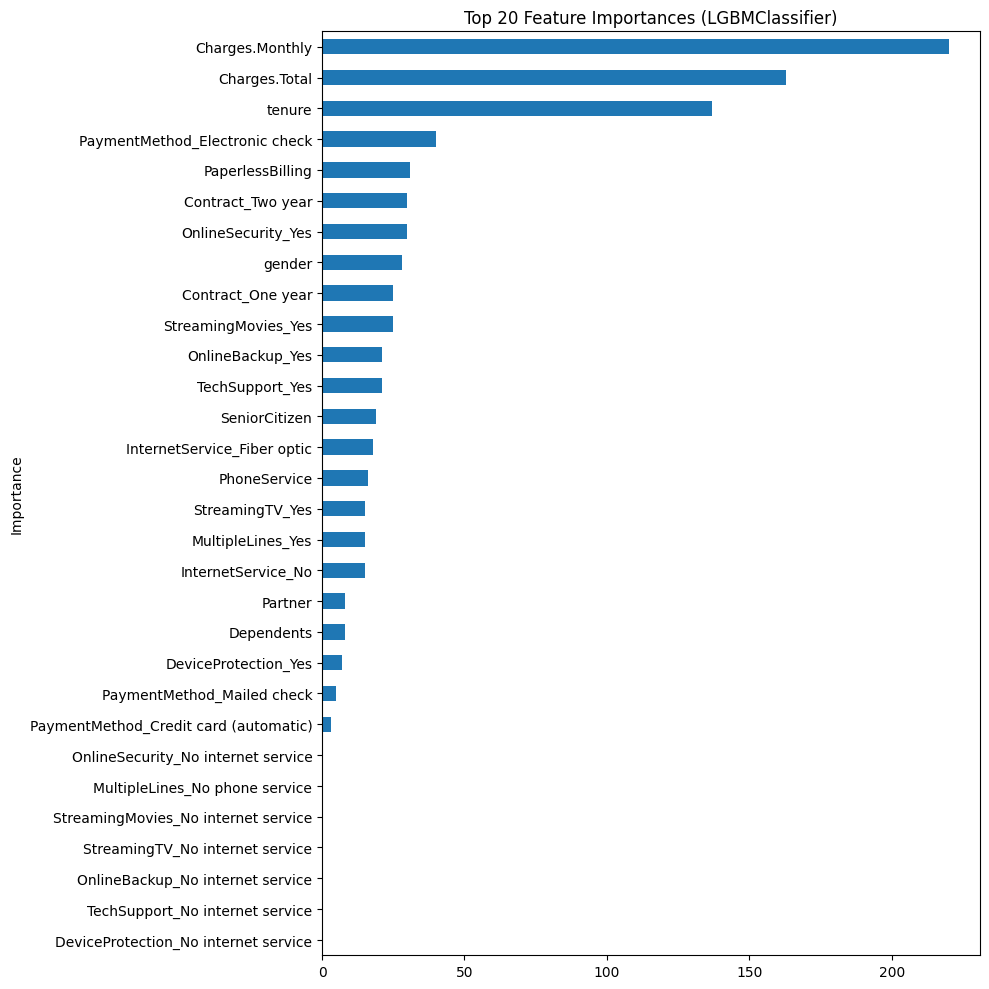

In [29]:
importances = lgbm.feature_importances_
feature_names = X_train.columns
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

print("Feature importances:")
print(feat_imp)

plt.figure(figsize=(10, 10))
feat_imp.sort_values().plot(kind='barh')
plt.title("Top 20 Feature Importances (LGBMClassifier)")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()


In [30]:
df.corr()[target_col].abs().sort_values(ascending=False)
# Calculate Pearson correlation coefficients between all features and the target
pearson_corr = df.corr(method='pearson').abs()[target_col].sort_values(ascending=False)
print(pearson_corr)


Churn                                    1.000000
tenure                                   0.352229
InternetService_Fiber optic              0.308020
Contract_Two year                        0.302253
PaymentMethod_Electronic check           0.301919
InternetService_No                       0.227890
OnlineSecurity_No internet service       0.227890
TechSupport_No internet service          0.227890
DeviceProtection_No internet service     0.227890
StreamingTV_No internet service          0.227890
StreamingMovies_No internet service      0.227890
OnlineBackup_No internet service         0.227890
Charges.Total                            0.199484
Charges.Monthly                          0.193356
PaperlessBilling                         0.191825
Contract_One year                        0.177820
OnlineSecurity_Yes                       0.171226
TechSupport_Yes                          0.164674
Dependents                               0.164221
SeniorCitizen                            0.150889


/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


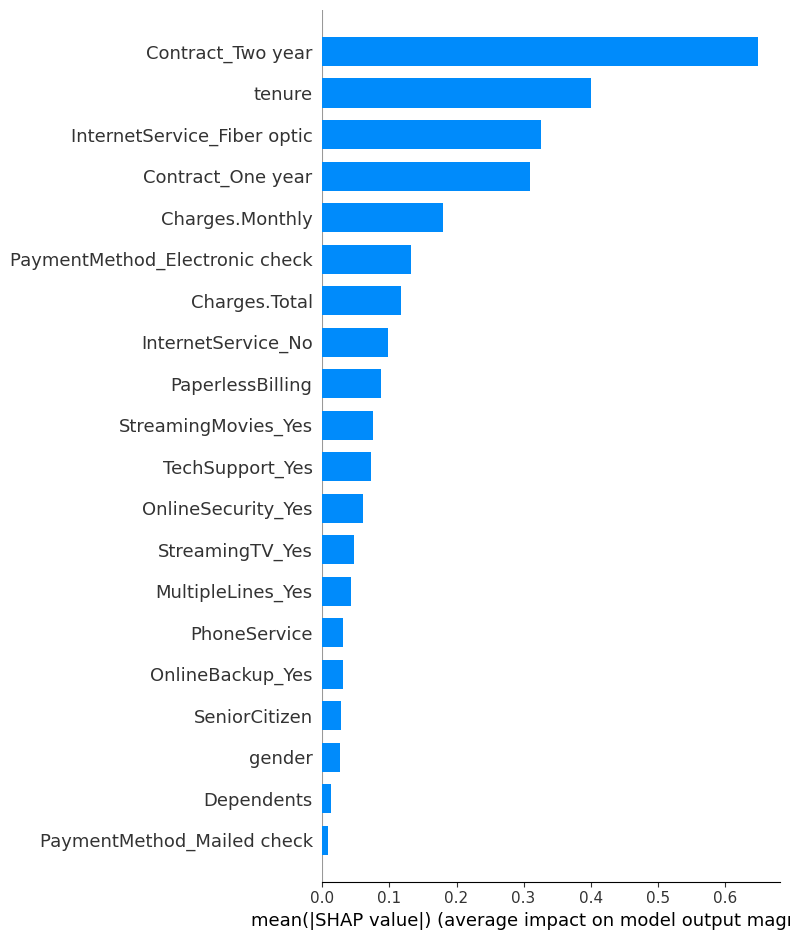

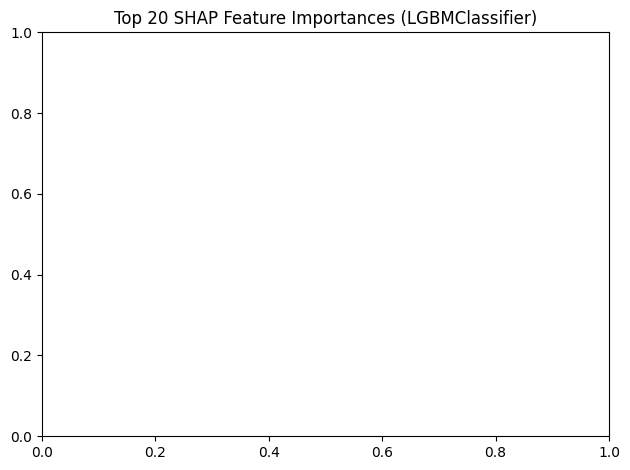

In [31]:
import shap

# Calculate SHAP values
explainer = shap.TreeExplainer(lgbm)
shap_values = explainer.shap_values(X_train)

# Plot SHAP feature importance (summary plot)
plt.figure(figsize=(10, 10))
shap.summary_plot(shap_values, X_train, plot_type="bar", max_display=20)
plt.title("Top 20 SHAP Feature Importances (LGBMClassifier)")
plt.tight_layout()
plt.show()


**Relatório de Análise de Evasão de Clientes**

Com base na análise dos dados dos clientes e no desempenho do modelo LGBMClassifier, os seguintes fatores têm a influência mais significativa na evasão de clientes:

**Principais Fatores de Evasão** (Com Base na Importância de Atributos e Valores SHAP)

**Tempo de Permanência (Tenure):** A duração do tempo que um cliente está com a empresa é um forte indicador de evasão. Clientes com menor tempo de permanência são mais propensos a sair. Isso é evidente tanto na importância dos atributos quanto nos valores SHAP, onde tenure consistentemente ocupa uma posição alta.

**Serviço de Internet** (Fibra Óptica vs. Sem Serviço de Internet): O tipo de serviço de internet impacta significativamente a evasão. Clientes com internet de Fibra Óptica são mais propensos a sair em comparação com aqueles sem serviço de internet. Os atributos InternetService_Fiber optic e InternetService_No têm alta importância e valores SHAP.

**Tipo de Contrato (Mês a Mês vs. Dois Anos):** Clientes com contratos mês a mês têm uma taxa de evasão muito maior do que aqueles com contratos de um ou dois anos. Isso é claramente mostrado pela alta importância e valores SHAP de Contract_Two year e Contract_One year.

**Método de Pagamento (Cheque Eletrônico):** Clientes que usam cheques eletrônicos como método de pagamento são mais propensos à evasão. O atributo PaymentMethod_Electronic check é um preditor significativo de evasão.

**Cobranças (Mensal e Total):** Tanto as cobranças mensais quanto as totais têm um impacto notável na evasão. Cobranças mensais mais altas e cobranças totais mais baixas tendem a estar associadas à evasão.

**Segurança Online e Suporte Técnico:** Clientes que não possuem serviços de segurança online ou suporte técnico são mais propensos a sair. A ausência desses serviços (OnlineSecurity_No internet service, TechSupport_No internet service, OnlineSecurity_Yes e TechSupport_Yes) são fatores importantes.

**Conta Sem Papel (Paperless Billing):** Clientes com conta sem papel são ligeiramente mais propensos a sair.

**Idoso (Senior Citizen):** Clientes idosos parecem ter uma propensão ligeiramente maior à evasão.

**Desempenho do Modelo**

O modelo LGBMClassifier alcançou uma acurácia de validação de aproximadamente 79.42% e um score ROC AUC de 0.8448. O relatório de classificação mostra que o modelo tem maior precisão e recall para prever clientes que não sairão (classe 0) em comparação com clientes que sairão (classe 1). Isso indica um desequilíbrio no conjunto de dados, que também é refletido nas contagens de valores da variável alvo (cerca de 73% não evasão e 27% evasão).

**Estratégias de Retenção**
Com base nesses resultados, aqui estão algumas estratégias de retenção propostas:

**Foco no Engajamento Inicial:** Implementar estratégias para engajar novos clientes com menor tempo de permanência para construir lealdade e reduzir a evasão inicial.

**Melhorar o Serviço de Fibra Óptica e Suporte:** Investigar possíveis problemas com o serviço de internet de Fibra Óptica que possam estar causando evasão e melhorar o suporte técnico para esses clientes.

**Promover Contratos de Longo Prazo:** Oferecer incentivos e benefícios para encorajar os clientes a mudarem de contratos mês a mês para contratos de maior duração.

**Analisar Problemas com Pagamento por Cheque Eletrônico:** Investigar se existem problemas específicos ou frustrações associadas ao método de pagamento por cheque eletrônico que contribuem para a evasão.

**Revisar Preços e Pacotes:** Analisar a relação entre altas cobranças mensais e evasão para garantir preços competitivos e considerar a oferta de pacotes mais flexíveis ou combinados.

**Destacar os Benefícios de Segurança e Suporte:** Promover ativamente os benefícios dos serviços de segurança online e suporte técnico aos clientes, especialmente aqueles que atualmente não os assinam.

**Avaliar a Experiência da Conta Sem Papel:** Coletar feedback sobre a experiência da conta sem papel e fazer melhorias, se necessário, para reduzir qualquer evasão associada.

**Personalizar Ofertas para Idosos:** Desenvolver programas de retenção ou ofertas direcionadas especificamente para clientes idosos.

Ao abordar esses fatores-chave e implementar estratégias de retenção direcionadas, a empresa pode potencialmente reduzir a evasão de clientes e melhorar o valor geral do tempo de vida do cliente.